## Step 1 - concatenation

*The code in this repository is shared under the GPLv3+ license, by Maxime Woringer, Mar. 2021*

### input data
A Micromanager folder, in which several positions were imaged multiple times, leading to a folder structure as follows:

```
├── 20200221_release_1
│   ├── 20200221_release_1_MMStack_Pos1.ome.tif
│   ├── 20200221_release_1_MMStack_Pos2.ome.tif
│   ├── 20200221_release_1_MMStack_Pos3.ome.tif
│   ├── 20200221_release_1_MMStack_Pos4.ome.tif
│   ├── 20200221_release_1_MMStack_Pos5.ome.tif
│   └── displaySettings.txt
├── 20200221_beforeattr_2
│   ├── 20200221_beforeattr_2_MMStack_Pos1.ome.tif
│   ├── 20200221_beforeattr_2_MMStack_Pos2.ome.tif
│   ├── 20200221_beforeattr_2_MMStack_Pos3.ome.tif
│   ├── 20200221_beforeattr_2_MMStack_Pos4.ome.tif
│   ├── 20200221_beforeattr_2_MMStack_Pos5.ome.tif
│   └── displaySettings.txt
├── 20200221_beforeattr_3
│   ├── 20200221_beforeattr_3_MMStack_Pos1.ome.tif
│   ├── 20200221_beforeattr_3_MMStack_Pos2.ome.tif
│   ├── 20200221_beforeattr_3_MMStack_Pos3.ome.tif
│   ├── 20200221_beforeattr_3_MMStack_Pos4.ome.tif
│   ├── 20200221_beforeattr_3_MMStack_Pos5.ome.tif
│   └── displaySettings.txt
├── 20200221_beforeattr_4
│   ├── 20200221_beforeattr_4_MMStack_Pos1.ome.tif
│   └── displaySettings.txt
```

### output data
This scripts creates one movie per position (named with the position number), and recovers the timestamps of the individual frames. The timestamps are exported as a `.xls` file, and overlaid in the concatenated file. 
Finally, if the timestamp when the magnet was added/removed is present in the configuration (`.cfg`) file, then *(ON|OFF)* flag is present both in the `.xls` file and in the movie overlay.

**IMPORTANT NOTE:** the concatenated file contain metadata about the pixez size (in x, y and z). This metadata is retrieved from the MicroManager metadata. Make sure that this value is filled (and filled properly). If this is not the case, you can edit the `concat.py` file to change the `inject_pixel_size` variable to `True` and the `inject_pixel_size_value` to the actual pixel size.

**IMPORTANT NOTE 2:** The datasets acquired on 20190410 and 20190415 have an incorrect pixel size in x and y. The correct pixel size should be 0.0867 µm.

```
├── concatenated_Pos1.ome.tif
├── concatenated_Pos2.ome.tif
├── concatenated_Pos3.ome.tif
├── concatenated_Pos4.ome.tif
├── concatenated_Pos5.ome.tif
├── files_concatenated.txt
├── timestamps_Pos1.xls
├── timestamps_Pos2.xls
├── timestamps_Pos3.xls
├── timestamps_Pos4.xls
└── timestamps_Pos5.xls
```

### parameters of this script
This script takes very little parameters, they are located in two `.cfg` files in the `config` folder, and in the first cell below.

#### `datasets.cfg`

Datasets are represented as sections ; sections are delimited by headers [section_name]. Each section should contain:
- A `lfn` variable, should be a Python list that contains the list of folders to include for the concatenation. This allows including/excluding folders that should/should not be concatenated
- A `forceOn` variable, a list of list, each inner list should contain the timestamp when the magnet was added, the removed. The list can contain multiple lists if the magnet was added/removed several time.
  - Example 1: magnet added at 16:00:00, removed at 16:30:00: `forceOn = [['2020-02-21 16:00:00', '2020-02-21 16:30:00']]`
  -  Example 2: in addition the magnet was re-added at 17:00 and re-removed at 17:30: `forceOn = [['2020-02-21 16:00:00', '2020-02-21 16:30:00'], ['2020-02-21 17:00:00', '2020-02-21 17:30:00']]`
- A `directory` variable, corresponding to the folder to be used in steps 7+.
- `force_field`: the name of a force field (defined in details in `config.cfg`
- `mnp_calibration`: a dict corresponding to the number of MNPs in a given movie, at a given frame (1-indexed), where the locus is located at the x/y locations. 

### Documentation of the output file
The file `./docs/documentation.html` describes the column names of the .csv files.

In [1]:
## Imports // DO NOT EDIT
running_in_jupyter = True

import os, subprocess, shutil, datetime, sys
import chromag_helper as chromag
import chromag_segment as segment

__version__ = "v2.4.0a"

running_in_jupyter = chromag.pre_init(__version__)

Working with the version v2.4.0a (commit 306a58d), last updated on Thu Apr 8 08:44:08 2021 +0200


In [4]:
## ========      ===========
## Selection of the config file
## ========      ===========
## All the configuration is in the CFG files. Here, only edit the selected folder if needed
## You can edit this if you want, overriden if running outside IPython // 
# Current options (also listed below): Array7, PFS2, 20200221, L20190410, L20190415, 20210623, 20210719, 20210721, 20210723
## Previous analyses are saved in the file `concatenate_archive.py`

dataset_to_run = "20200221" # refers to the section in the .cfg file

## ==== Do not edit below this point ====
config_paths = {'datasets' : "config/datasets.cfg", 'main' : "config/config.cfg"} ## Load config files
config, dataset_to_run = chromag.init_config(config_paths, dataset_to_run, 
                                             is_jupyter=running_in_jupyter, verbose=True) ## First, read & process the config files
posidict, fn = chromag.list_files_positions(config['prefix_path'], config['CCresult_path'], config['use_analysis'], 
                                            config['lfn'], __version__, config['forceOn'], 
                                            verbose=True, save_log=True) ## Then, we will list the input files, output folders, etc.

The following datasets are available:
 0: 20210723: 	 data/Maxime/concatenation/Antoine/20210723/
 1: 20210721: 	 data/Maxime/concatenation/Antoine/20210721/
 2: 20210719: 	 data/Maxime/concatenation/Antoine/20210719/
 3: 20210623: 	 data/Maxime/concatenation/Antoine/20210623/
 4: 20200221: 	 data/Maxime/concatenation/Antoine/20200221/
 5: Array7: 	 data/Maxime/concatenation/Veer/20191223 - array7/
 6: PFS2: 	 data/Maxime/concatenation/Veer/20191217 - PFS2/
 7: L20190410: 	 data/Maxime/concatenation/Laura/20190410/20210326/
 8: L20190415: 	 data/Maxime/concatenation/Laura/20190415/20210326/
The following dataset has been selected: 20200221

Available positions/sequence
                                                   0  1  2  3  4  5  \
Sequence                                                              
Antoine/20200221/20200221_U2OS_stTetR-mCherry_G...    *  *  *  *  *   
Antoine/20200221/20200221_U2OS_stTetR-mCherry_G...    *  *  *  *  *   
Antoine/20200221/20200221_U2OS_stTetR-

## [1] Effectively concatenating files [independent block 1]
Because file concatenation seems to be a mess, we decide to rely on Fiji to perform this step.

This step uses `concat.py`, a Fiji macro. /!\ Make sure you do not delete them/edit it without care :)

In [ ]:
## Running the concatenation
## Be careful that imageJ-scifio might not read the overlay properly :s
## note that useful debug information will be displayed in the console
## A special function chromag.manual_concatenation() can be customed to concatenate hard-to-concatenate files.

assert os.path.isdir(fn), "ERROR: output folder {} does not exists".format(fn)
assert chromag.has_screen(), "No display found, are you connected using `ssh -X`?"
ddf = chromag.save_timestamps(config['prefix_path'], fn, posidict, config['system'], 
                              fieldOn=config['forceOnP'], force_overwrite=False) ## Extract .xls spreadsheets with timestamps
chromag.concatenate(fn, posidict, ddf, config, channels=[0,1]) # a wrapper to a Fiji script

## [2] Register all pillars and select all the cells

Here you whould use the `cell_selection.ijm` Fiji macro. It will create a .txt file for each concatenated file. Concatenated movies without a .txt file will not be processed.

**/!\\ IMPORTANT:** This is a manual step that should be performed by running the Fiji macro on each individual concatenated file.

## [3] Compute the bandpassed versions of the movies and crop individual cells

Note that this requires a lot of memory, and thus we tell Java/Fiji to allocate 40 GB of memory. This parameter
can be tuned, using the `-Xmx40G` flag (to allocate 20GB instead, replace the flag with `-Xmx20G`).

The `bandpass` and `crop` functions are wrappers that makes an external call to Fiji, things might go wrong when it is called. Additional debug info is displayed in the console.

In [10]:
chromag.bandpass(fn, posidict, config) ## Compute the bandpassed versions

Computing bandpassed for concatenated_Pos1.ome.tif, with parameters sd1 = 0.8, sd2 = 10
Computing bandpassed for concatenated_Pos2.ome.tif, with parameters sd1 = 0.8, sd2 = 10
Computing bandpassed for concatenated_Pos3.ome.tif, with parameters sd1 = 0.8, sd2 = 10
File /data2/Dropbox/CoulonLab/data/Maxime/concatenation/Antoine/20200221/20220214/concatenated_Pos4.ome.tif will not be included in further analysis
File /data2/Dropbox/CoulonLab/data/Maxime/concatenation/Antoine/20200221/20220214/concatenated_Pos5.ome.tif will not be included in further analysis
Done!


In [ ]:
# crop could be made much faster by loading only once each file.
lf, lfDC, lfDC_all = chromag.crop(fn, config, correction_type="none", followLocus=False, verbose=True) ## Extract individual cells

## [4] Extract initial force

The initial force (`Fstart`) is useful to determine whether a cell should be analyzed in full. To be able to compute this initial force, we retrieve the location of the pillar and the manual pointing of the locus at a time around zero (the first time point after the magnet was added).

This step uses the `ff_p` field in `config.cfg`, make sure that you configured it properly.

We first locate the pillar, to be able to get a distance to the pillar, and an estimate of the force.
- Load and plot the pillar on the first frame of the data
- Load the force profile

Loading force field: array1ferritinH
Reading 20210222_Simulated_Force_array1b-ferritinH_field_z-3um_Msat-pillar-3.67e5_Msat-MNP-8.5e-20_Bext-100mT_corner-10um_angle3.4deg_Refine-2-2-2_rescaled-px-130nm_bot_Fxyz.tif


/data/CoulonLab/Maxime/jupyter/jupyter/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


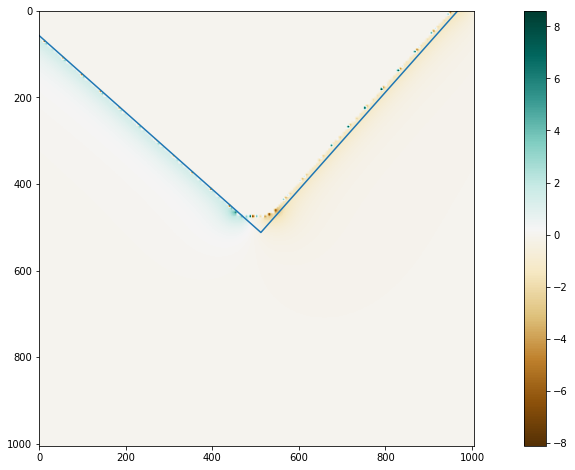

In [13]:
imgF, r_force, px_size, config['simulated_pillar_pointing_down'] = chromag.forcefield(fn, config['ff_p'], config['project_path'], config['prefix_path'], 
                                            force_name=config['force_field'])

In [15]:
## OPTIONAL: Provide a table with an estimate of the initial force.
chromag.list_Fstart(lf, lfDC, imgF, px_size, r_force, config, verbose=False)

Field px size: 0.130, Experiment px size: 0.1287, zooming the force field by a factor: 1.0101010101010102
Field px size: 0.130, Experiment px size: 0.1287, zooming the force field by a factor: 1.0101010101010102
Field px size: 0.130, Experiment px size: 0.1287, zooming the force field by a factor: 1.0101010101010102
Field px size: 0.130, Experiment px size: 0.1287, zooming the force field by a factor: 1.0101010101010102
Field px size: 0.130, Experiment px size: 0.1287, zooming the force field by a factor: 1.0101010101010102
Field px size: 0.130, Experiment px size: 0.1287, zooming the force field by a factor: 1.0101010101010102
Field px size: 0.130, Experiment px size: 0.1287, zooming the force field by a factor: 1.0101010101010102
Field px size: 0.130, Experiment px size: 0.1287, zooming the force field by a factor: 1.0101010101010102
Fit did not converge, file: /data2/Dropbox/CoulonLab/data/Maxime/drift-correction/Antoine/20210723/20210727/concatenated_Pos3DC2.ome.tif
 initial point:

,movie,cell,Fstart_per_MNP_fN,Fstart_per_locus_pN,MNPs,Fx_start_per_MNP_fN,Fy_start_per_MNP_fN,Fz_start_per_MNP_fN
0,concatenated_Pos0.ome.tif,0,0.655895,0.188594,287.537590,0.461130,0.444983,0.139812
1,concatenated_Pos0.ome.tif,1,0.340654,0.406964,1194.653236,0.278180,0.177678,0.084213
2,concatenated_Pos0.ome.tif,2,0.550553,0.312822,568.195833,-0.366853,0.381876,0.150659
3,concatenated_Pos0.ome.tif,3,0.547366,1.732477,3165.114270,-0.376275,0.368878,0.148174
4,concatenated_Pos0.ome.tif,4,0.228451,0.322101,1409.935142,-0.167962,0.147227,0.047985
5,concatenated_Pos3.ome.tif,0,0.292946,0.588775,2009.838514,0.049586,0.284989,0.046263
6,concatenated_Pos3.ome.tif,1,0.119551,0.311735,2607.557501,-0.091798,0.074277,0.018665
7,concatenated_Pos3.ome.tif,2,0.097763,0.175307,1793.186244,0.083105,0.048409,0.017544
8,concatenated_Pos3.ome.tif,3,0.150415,0.449708,2989.783758,-0.085918,0.121830,0.020001
9,concatenated_Pos3.ome.tif,4,0.013576,0.049374,3636.771445,-0.000182,0.013559,0.000666


## [5] Track loci

You should run `trackUsingMouse` on all the extracted cells.

**/!\\ IMPORTANT:** This is a manual step that should be performed by running the `trackUsingMouse` notebook on each individual concatenated file.

Here we perform a 2D+1D fitting (the locus is first localized at subpixel resolution in (x,y), and then the z coordinate is determined by finding the plane of highest intensity at the locus.

Notes:
- `init_crop`: runs a Fiji macro to extract the locus channel, debug information is provided in the console.
- `track_subpixel`: you can tune `border` (ideally: 3) if you get a lot of 'Aborting! without computation, the selection (partially) lies outside the image' messages

In [14]:
lfTR_all, config['mtrk_cvfn'] = chromag.init_track(fn, lfDC_all, config['fiji_path'], force_overwrite=False, verbose=True) # extract locus channel

## ==== TODO MW (v2.0) ====
## Integrate an interactive version of trackUsingMouse
## And document which files should be created.
## The output of this step is to create a .mtrk (manual tracking) file, that represents a gross tracking,
##+that is then refined at subpixel resolution.

# Actually the extraction of the _MAX file could be removed, since trackUsingMouse was updated.

1/7: concatenated_Pos3DC0_MAX.ome.tif: OK
2/7: concatenated_Pos3DC1_MAX.ome.tif: OK
3/7: concatenated_Pos3DC2_MAX.ome.tif: OK
4/7: concatenated_Pos2DC0_MAX.ome.tif: OK
5/7: concatenated_Pos2DC1_MAX.ome.tif: OK
6/7: concatenated_Pos1DC0_MAX.ome.tif: OK
7/7: concatenated_Pos1DC1_MAX.ome.tif: OK
The script 'max_intensity_projection.tmp.ijm' was created
Done!


In [15]:
## This function does not have to be re-run every time
# border should be set to 3 for 20191223
# border should be set to 7 for 20191217
chromag.track_subpixel(fn, lfTR_all, lfDC_all, mtrk_cvfn=config['mtrk_cvfn'], select="", border=3, skip=-1, dbg=False, verbose=False)
#chromag.track_debug("22DC3", lfTR_all, lfDC_all, ch=1)  # DBG: useful to see how tracking/convergence performs

1/7: Fitting: concatenated_Pos3DC0.ome.tif
2/7: Fitting: concatenated_Pos3DC1.ome.tif
3/7: Fitting: concatenated_Pos3DC2.ome.tif
4/7: Fitting: concatenated_Pos2DC0.ome.tif
5/7: Fitting: concatenated_Pos2DC1.ome.tif
6/7: Fitting: concatenated_Pos1DC0.ome.tif
7/7: Fitting: concatenated_Pos1DC1.ome.tif
Summary of fitting:
1: [No tracking data] concatenated_Pos3DC0.ome.tif
2: [No tracking data] concatenated_Pos3DC1.ome.tif
3: [No tracking data] concatenated_Pos3DC2.ome.tif
4: [No tracking data] concatenated_Pos2DC0.ome.tif
5: [No tracking data] concatenated_Pos2DC1.ome.tif
6: [No tracking data] concatenated_Pos1DC0.ome.tif
7: [No tracking data] concatenated_Pos1DC1.ome.tif
Done!


## [6] Data analysis

#### Data preparation

- Compute the overlay
- Overlay over time in DC'd movies
- Load segmentation if there is one
- Compute direction of the force -> extract parallel and transverse motion
- Bind the environment of the locus, oriented
- Segment the cell

**About the `ff_p` variable**: this variable is defined in the file `config/config.cfg` and makes the correspondance between the given name of a forcefield, and the location of the file. It can handle many has the following structure:
- it is a dictionary, with the *key*: given name of the force field (str)
- the value is a tuple: 
  - first field: relative path to the .tif file containing the 3D force field.
  - second field: related to the number of dimensions of the file (not sure how, though)
  - third field: whether orientation and pixel size exist in an adjacent .txt file

In [ ]:
## This step takes a lot of time :/ It may also contain a big memory leak...
chromag.export_csv(fn, lf, lfDC, imgF, r_force, px_size, config, 
                   ignore=[(0,0), (0,1), (1,0), (2,0), (2,1), (3,0), (3,1)], # [(1,0)] #3DC0, need to be added for Array7
                   ignore_missing = True,
                   select="", #  a pattern to select (e.g: "Pos11_cell0")
                   plot=True, export_pdf=True)

## [7] Cell segmentation

In [8]:
config_segment = segment.segment_init(config['directory'], config['prefix'])
segment.segment(config_segment, force_overwrite=False, select="", verbose=True) # select=Pos2DC0, empty string to deactivate

## [8] Analyzing the masks

- Next steps: 
- 1. make plots (locus, image, direction of the force, segmentation)
- 2. Add metrics to table
- 3. Compute the (x,y) coordinates of the centroid of the cell
- 4. Compute $(\bar Fx_n,\bar Fy_n,\bar Fz_n)$ basis vector, normalized and center it on the centroid

In [17]:
chromag.export_csv2(config_segment, # export the "_2.csv" files
                    select="Pos4DC0", #"Pos25DC3" (str, default: ''): a string pattern used to only process some files. For instance 'Pos0DC0'. 
                    select_f=[], # frame(s) to select, a list, -1 or empty list to process everything
                    verbose=True)

processing 2/2
Reading concatenated_Pos4DC0.ome.tif
All done!


## [9] Estimate bleaching over time

For all the files, we want to compute the histogram of intensities, and see how it evolves over time, we will compute the mean signal and its standard deviation.
- We will create a dataframe for this
- We will then export several normalized files, named _normXXX, where XXX stands for the normalization technique. The normalized channel will be set in an additional channel. (optional, and will happen later)

In [ ]:
dff = chromag.bleach_correction(config_segment, plot=True, save_plot=True, verbose=True)

## [10] Export _3.csv file

Here we merge all the files we need for the analysis. The files ending in _3.csv contain most of the information needed for data processing.

In [ ]:
chromag.export_csv3(fn, dff, config['qc_mnp_file'], config_segment, plot=True, verbose=True)

## [11] Export movies

We first export the movies without the overlays

We then create a new folder: exports, that should contain:
- _rot_cLocus (with _norot and _rot1d variations)
- _rot_cCentroid (with _norot and _rot1d variations)
- _3.csv

In [ ]:
## This step takes a long time :)

exports = [ # List here what we should export
    {'center':'centroid', 'rotated':True, 'save1d':False, 'cropsize':(300,300)}, # *_rot_cCentroid
    {'center':'centroid', 'rotated':True, 'save1d':True, 'cropsize':(300,300)},  # *_rot1d_cCentroid
    #{'center':'locus', 'rotated':True, 'save1d':False, 'cropsize':(300,300)},    # *_rot_cLocus
    #{'center':'locus', 'rotated':True, 'save1d':True, 'cropsize':(300,300)},     # *_rot1d_cLocus
    #{'center':'centroid', 'rotated':False, 'save1d':False, 'cropsize':(300,300)}, # *_norot_cCentroid
]
chromag.export_tif(config_segment, exports, select="", force_overwrite=True, verbose=True)

In [ ]:
config['directory_export'], excl = chromag.export_init(config)
chromag.export_overlay(config_segment['img_p'], exports, excl, config, 
                       normalize=False, force_overwrite=False, verbose=True)